In [1]:
from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import os

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
import IPython.display as ipd
import wave

In [5]:
timing = pd.read_csv('../csvFiles/set_a_timing.csv')

In [6]:
S1 = dict()
S2 = dict()
noise_1 = dict()
noise_2 = dict()

file_name = list(timing['fname'].unique())

for i in file_name:
    S1[i] = []
    S2[i] = []
    noise_1[i] = []
    noise_2[i] = []

for i in range(len(timing)):
    if timing.sound[i] == 'S1':
        S1[timing.fname[i]].append(timing.loc[i,'location'])
        noise_1[timing.fname[i]].append(timing.loc[i,'location']+1500)
    else:
        S2[timing.fname[i]].append(timing.loc[i,'location'])
        noise_2[timing.fname[i]].append(timing.loc[i,'location']+1500)

In [7]:
def frames_to_TC_ms (frames):
    h = int(frames / 158760000) # 60*60*44100
    m = int(frames / 2646000) % 60  # 60*44100
    s = int((frames % 2646000)/44100)
    f = frames % 2646000 % 44100
    return s*1000

In [8]:
from datetime import timedelta

FPS = 44100
frame_count = 347886
td = timedelta(seconds=(frame_count / FPS))
print(str(td)[6:])


7.888571


In [9]:
from pydub import AudioSegment

/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [10]:
# Corte de S1
FPS = 44100
for k in file_name:
    obj = wave.open('../'+k, mode='rb')
    td = timedelta(seconds=(obj.getnframes()/ FPS))
    a = str(td)[6:]
    print(float(a)*1000) # tempo total do audio em ms
    #print("Time: ", frames_to_TC_ms(obj.getnframes()))
    for i in range(len(S1[k])):
        framesS1 = S1[k][i] # local de corte S1
        framesNoise = S1[k][i]+1500 # local de corte de fim S1
        a = timedelta(seconds=(framesS1/ FPS)) # transforma em tempo, em segundos
        b = timedelta(seconds=(framesNoise/ FPS))
        t1_ = str(a)[6:] # corta a string de tempo
        t2_ = str(b)[6:]
        t1_ms = float(t1_)*1000 # transforma a string de volta em float, em milisegundos
        t2_ms = float(t2_)*1000
        path = '../' + k
        newAudio = AudioSegment.from_wav(path)
        newAudio = newAudio[t1_ms:t2_ms] # corta os audios
        nameCut = k[5:26]
        newName = '../set_a_cut' + nameCut + '_S1_' + str(i) + '.wav'
        newAudio.export(newName, format = 'wav')

7888.571
6284.1269999999995
8013.923
9000.0
8013.923
9000.0
3463.424
7637.891
9000.0
7997.211
9000.0
7537.596
4963.787
5749.2970000000005
5849.592000000001
7002.789
9000.0
7935.5560000000005
7935.5560000000005
7935.5560000000005
7935.5560000000005


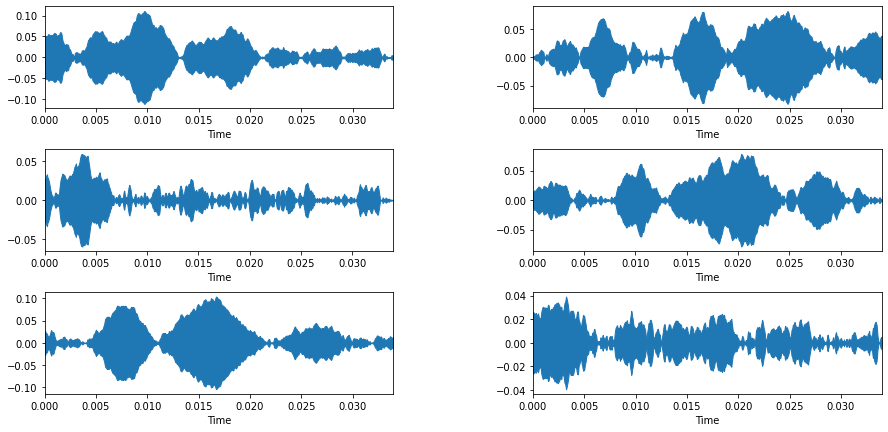

In [11]:

fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(6):
    fig.add_subplot(6,2,1+i)
    name = '../set_a_cut/normal__201102081321_S1_'+str(i)+'.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)
    


In [12]:
# Corte de S2
FPS = 44100
for k in file_name:
    obj = wave.open('../'+k, mode='rb')
    td = timedelta(seconds=(obj.getnframes()/ FPS))
    a = str(td)[6:]
    # print(float(a)*1000) # tempo total do audio
    # print("Time: ", frames_to_TC_ms(obj.getnframes()))
    for i in range(len(S2[k])):
        framesS2 = S2[k][i] # local de corte S2
        framesNoise = S2[k][i]+1500 # local de corte de fim S2
        a = timedelta(seconds=(framesS2/ FPS)) # transforma em tempo, em segundos
        b = timedelta(seconds=(framesNoise/ FPS))
        t1_ = str(a)[6:] # corta a string de tempo
        t2_ = str(b)[6:]
        t1_ms = float(t1_)*1000 # transforma a string de volta em float, em milisegundos
        t2_ms = float(t2_)*1000
        path = '../' + k
        newAudio = AudioSegment.from_wav(path)
        newAudio = newAudio[t1_ms:t2_ms] # corta os audios
        nameCut = k[5:26]
        newName = '../set_a_cut' + nameCut + '_S2_' + str(i) + '.wav'
        newAudio.export(newName, format = 'wav')

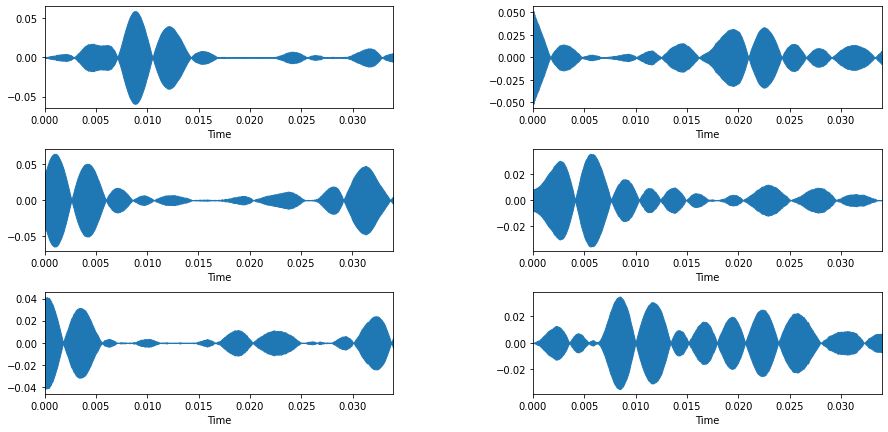

In [13]:

fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(6):
    fig.add_subplot(6,2,1+i)
    name = '../set_a_cut/normal__201102260502_S2_'+str(i)+'.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)

In [14]:
# Corte de ruido
for k in file_name:
    obj = wave.open('../'+k, mode='rb')
    td = timedelta(seconds=(obj.getnframes()/ FPS))
    a = str(td)[6:]
    # print(float(a)*1000) # tempo total do audio
    # print("Time: ", frames_to_TC_ms(obj.getnframes()))
    for i in range(len(noise_1[k])):
        framesNoise = noise_1[k][i] # local de corte de ruido
        framesS2 = S2[k][i] # local de corte de fim do ruido (inicio do S2)
        a = timedelta(seconds=(framesNoise/ FPS)) # transforma em tempo, em segundos
        b = timedelta(seconds=(framesS2/ FPS))
        t1_ = str(a)[6:] # corta a string de tempo
        t2_ = str(b)[6:]
        t1_ms = float(t1_)*1000 # transforma a string de volta em float, em milisegundos
        t2_ms = float(t2_)*1000
        path = '../' + k
        newAudio = AudioSegment.from_wav(path)
        newAudio = newAudio[t1_ms:t2_ms] # corta os audios
        nameCut = k[5:26]
        newName = '../set_a_cut' + nameCut + '_noiseS1_' + str(i) + '.wav'
        newAudio.export(newName, format = 'wav')
        
for k in file_name:
    obj = wave.open('../'+k, mode='rb')
    td = timedelta(seconds=(obj.getnframes()/ FPS))
    a = str(td)[6:]
    # print(float(a)*1000) # tempo total do audio
    # print("Time: ", frames_to_TC_ms(obj.getnframes()))
    for i in range(len(noise_2[k])):
        framesNoise = noise_2[k][i] # local de corte de ruido
        for c in range(len(noise_2[k])-1):
            framesS1 = S1[k][c] # local de corte de fim do ruido (inicio do S1)
        a = timedelta(seconds=(framesNoise/ FPS)) # transforma em tempo, em segundos
        b = timedelta(seconds=(framesS1/ FPS))
        t1_ = str(a)[6:] # corta a string de tempo
        t2_ = str(b)[6:]
        t1_ms = float(t1_)*1000 # transforma a string de volta em float, em milisegundos
        t2_ms = float(t2_)*1000
        path = '../' + k
        newAudio = AudioSegment.from_wav(path)
        newAudio = newAudio[t1_ms:t2_ms] # corta os audios
        nameCut = k[5:26]
        newName = '../set_a_cut' + nameCut + '_noiseS2_' + str(i) + '.wav'
        newAudio.export(newName, format = 'wav')

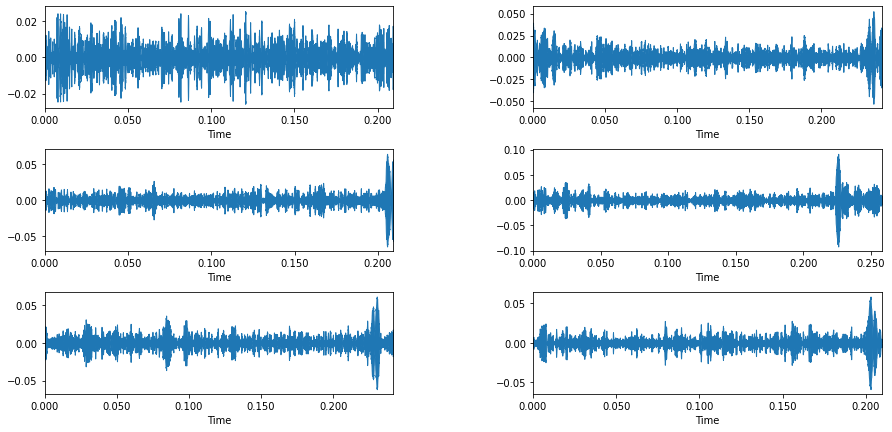

In [15]:
fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(6):
    fig.add_subplot(6,2,1+i)
    name = '../set_a_cut/normal__201102081321_noiseS1_' + str(i) + '.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)

/home/picopreto/.virtualenvs/taad/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


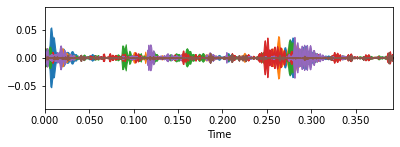

In [16]:
fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for k in range(6):
    fig.add_subplot(6,2,1+i)
    name = '../set_a_cut/normal__201102260502_noiseS2_' + str(k) + '.wav'
    data, sample_rate = librosa.load(name)
    librosa.display.waveplot(data, sr = sample_rate)